In [1]:
from itertools import product

import torch
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from torch import Tensor
from skimage.measure import label, regionprops
from skimage.morphology import disk
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

from berenike.models.segmenter import Segmenter
from berenike.evaluation import evaluate_detections

from train import model # get the model from the train.py file

/home/jatentaki/tumulusy/archeo/.venv/lib/python3.11/site-packages/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/home/jatentaki/tumulusy/archeo/.venv/lib/python3.11/site-packages/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/home/jatentaki/tumulusy/archeo/.venv/lib/python3.11/site-packages/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [2]:
def trim_to_8(chunk: Tensor) -> Tensor:
    """
    Trims the chunk to be a multiple of 8 in height and width.
    This is required for the model to work properly.

    Arguments:
        chunk: A chunk of data to trim. Numpy array of shape (C, H, W).
    
    Returns:
        A numpy array of shape (C, H', W') where H' and W' are multiples of 8.
    """
    _, h, w = chunk.shape
    h = (h // 8) * 8
    w = (w // 8) * 8

    return chunk[:, :h, :w]

def predict(model: Segmenter, chunk: np.ndarray) -> np.ndarray:
    """"
    Runs prediction on a multiple-of-8 chunk of data.
    
    Arguments:
        model: The model to run prediction on.
        chunk: A chunk of data to run prediction on. Numpy array of shape (C, H, W).
    
    Returns:
        A numpy array of shape (H, W) containing the predicted probabilities.
    """
    model_device = next(model.parameters()).device
    chunk = torch.from_numpy(chunk).to(model_device).float() / 255
    chunk = chunk.unsqueeze(0)
    with torch.inference_mode():
        prediction = model(chunk)
    p = prediction.sigmoid().squeeze(0).squeeze(0)
    
    # mask out black regions because some models predict clusters there
    # causing crazy slowness with skimage
    mask = (chunk == 0).squeeze(0).all(dim=0)
    p[mask] = 0
    return p.cpu().numpy()

In [3]:
TUMULUS_SIZE = disk(4).sum() # area of a disk with radius 4

def heatmap_to_pins(heatmap: np.ndarray) -> np.ndarray:
    """
    Converts a heatmap to discrete (x, y) coordinates approximating the tumuli detection locations.

    Each region in the heatmap is
    * rejected if smaller than TUMULUS_SIZE
    * returned as a single point if it is smaller than 2*TUMULUS_SIZE
    * clustered into multiple points using KMeans if it is larger than 2*TUMULUS_SIZE

    Arguments:
        heatmap: A numpy array of shape (H, W) containing the predicted probabilities.
    
    Returns:
        A numpy array of shape (N, 2) containing the (x, y) coordinates of the detected tumuli.
    """
    
    label_image = label(heatmap > 0.5)
    regions = regionprops(label_image)

    pins = []
    for region in regions:
        n_pins = int(region.area) // int(TUMULUS_SIZE)

        if n_pins == 0:
            continue
        if n_pins == 1:
            pins.append(region.centroid)
            continue

        kmeans = KMeans(n_clusters=n_pins, n_init=1)
        kmeans.fit(region.coords)
        pins.extend(kmeans.cluster_centers_)

    return np.array(pins)

In [4]:
def detect_chunked(model: Segmenter, bitmap: np.ndarray, chunk_size: int = 2048) -> np.ndarray:
    """
    Detects tumuli in a large bitmap by splitting it into smaller chunks and running the model on each chunk.
    This is required because the model cannot handle large images due to memory constraints.

    Arguments:
        model: The model to run prediction on.
        bitmap: A numpy array of shape (C, H, W) containing the image data.
        chunk_size: The size of the chunks to split the image into. Default is 2048.

    Returns:
        A numpy array of shape (N, 2) containing the (x, y) coordinates of the detected tumuli.
    """
    chunk_indices = list(product(
        range(0, bitmap.shape[1], chunk_size),
        range(0, bitmap.shape[2], chunk_size),
    ))

    all_pins = []
    for chunk_i, chunk_j in tqdm(chunk_indices):
        chunk = bitmap[:, chunk_i:chunk_i+chunk_size, chunk_j:chunk_j+chunk_size]
        chunk = trim_to_8(chunk) # the trimming applies only to the "edge" chunks since the rest are already multiples of 8
        
        heatmap = predict(model, chunk)
        pins = heatmap_to_pins(heatmap)
        if len(pins) == 0:
            continue

        chunk_offset = np.array([chunk_i, chunk_j])

        all_pins.append(pins + chunk_offset)
    
    return np.concatenate(all_pins)

In [5]:
# pick the best available accelerator
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")

Using device: cuda


In [6]:
checkpoint_path = "checkpoint.ckpt" # swap out for your training results if replicating
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['state_dict'])
model = model.eval().to(device)

In [7]:
# load the geotiff
with rasterio.open('data/Egypt_ortho_8bit.tif') as geotiff:
    bitmap = geotiff.read()
    meta = geotiff.meta.copy()

In [8]:
# detect pins in pixel coordinates
all_pins = detect_chunked(model, bitmap)

# convert to georeferenced coordinates. first we get the epsg:32636 coordinates
long, lat = geotiff.xy(*all_pins.T)

# then we convert to epsg:4326
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(long, lat), crs='epsg:32636')
gdf.geometry.to_crs('epsg:4326')

# save as geojson
gdf.to_file('user_detections.geojson', driver='GeoJSON')

  0%|          | 0/88 [00:00<?, ?it/s]

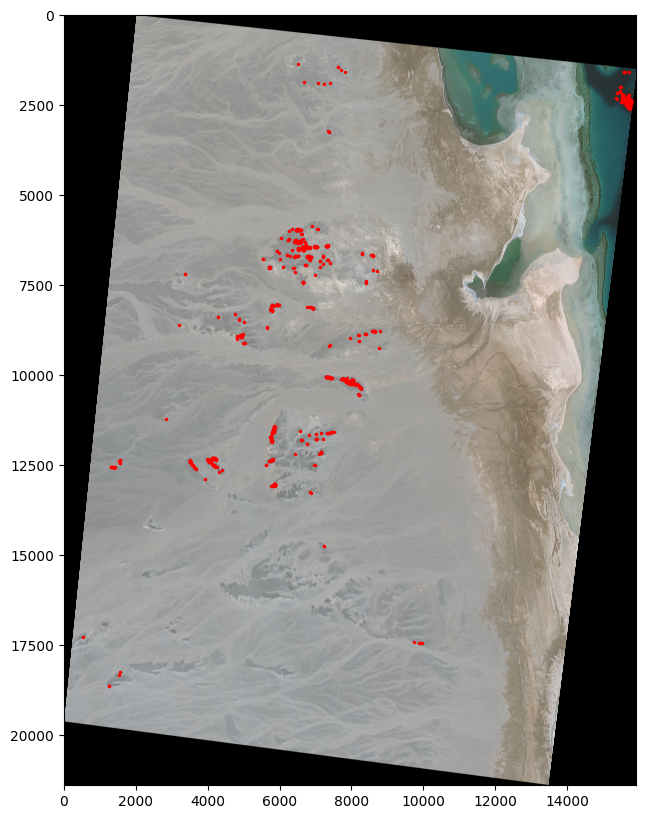

In [9]:
# plot the results (use GIS to view the geojson for proper exploration)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(bitmap.transpose(1, 2, 0))
x, y = all_pins.T
ax.scatter(y, x, s=2, c='red')

In [10]:
evaluate_detections(
    save_path="evaluation",
    ground_truth_path='data/annotations.geojson',
    # \/ swap out for "detections.json" to evaluate the "official" detections without running the model yourself
    detections_path='user_detections.geojson',
    validation_area_path='data/validation_area.geojson',
    buffer_distance=5,
)

Within evaluation area:
True Positives: 336
False Positives: 3
False Negatives: 23
Precision: 0.9912
Recall: 0.9359
F1 Score: 0.9628

Saving true positives, false positives, matched and unmatched annotations to save_path='evaluation'
